### Table of Contents
1. Problem statements      
1.1. Performance Measures  
2. Aims of the Project   
3. Importing necessary Libraries and Data    
4. Data summary & EDA   
4.1. Summary Statistics    
4.2. Data Visualization    
5. Data Pre-Processing   
5.1. Data Cleaning  
5.2. Train-test Split     
5.3. Transformation Pipelines  
6. Modeling    
6.1. Training on train split   
6.2. Cross-validation  
7. Fine-tuning  
7.1. Hypeparametrization       
7.2. Evaluate on test set   
8. Deployment 

3. Import Data

In [1]:
import os,sys
module_path = os.path.abspath(os.path.join("/home/miki/Desktop/Deployment/consumer-segmentation/src"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [3]:
from dataset import *

In [4]:
DATAPATH = '/home/miki/Desktop/Deployment/consumer-segmentation/data/raw/data.csv'

In [5]:
dfs = dataframe(DATAPATH)

4. Data summary & EDA   
4.1. Summary Statistics    

In [6]:
dfs

,Districts,water_prc,elect_prc,tel_prc
0,Haramaya,4.98,6.49,8.15
1,Qarsa,1.92,3.39,9.67
2,Haramaya,2.23,7.84,8.62
3,Haramaya,4.09,8.09,9.03
4,Haramaya,3.09,6.86,8.19
...,...,...,...,...
4495,Qarsa,1.47,6.22,10.95
4496,Grawa,5.47,4.01,1.80
4497,Grawa,8.48,3.07,0.93
4498,Grawa,5.29,1.52,3.36


In [7]:
from features import *

In [8]:
dfs.describe().T

,count,mean,std,min,25%,50%,75%,max
water_prc,4500.0,3.969093,2.108436,0.00,2.23,3.93,5.70,9.32
elect_prc,4500.0,4.867767,1.943055,0.08,3.36,4.58,6.46,10.41
tel_prc,4500.0,6.692047,3.532553,0.00,2.62,8.09,9.50,13.19


In [9]:
from features import *

4. Data summary & EDA       
4.2. Data Visualization 

In [10]:
checkDF(dfs)

The dataframe column have no any missing values
There are no duplication values observed
The dataframe column have no any missing values
There are no duplication values observed
The dataframe column have no any missing values
There are no duplication values observed
The dataframe column have no any missing values
There are no duplication values observed


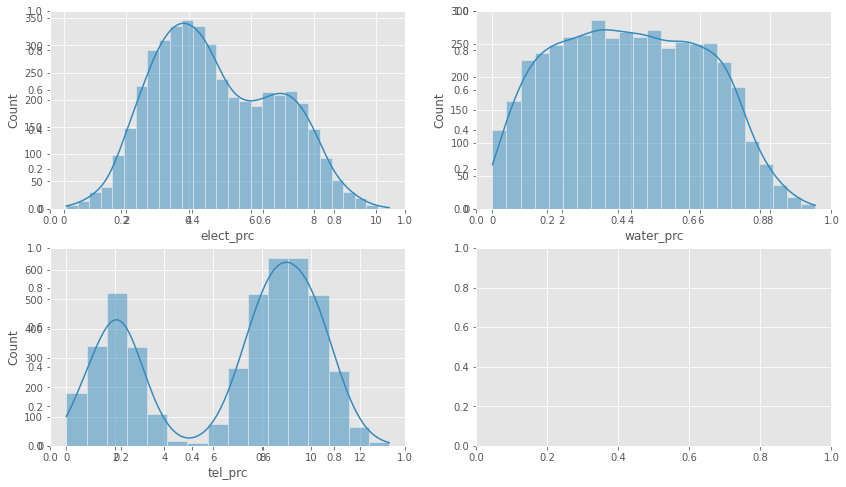

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 2, 1)
sns.histplot(dfs.elect_prc,ax=ax, kde=True)
ax = fig.add_subplot(2, 2, 2)
sns.histplot(dfs.water_prc,ax=ax, kde=True)
ax = fig.add_subplot(2, 2, 3)
sns.histplot(dfs.tel_prc,ax=ax, kde=True)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();


In [12]:
def pairplot(data, figures: str = '.'):
    """Function to create the scatter plot for the comparison of 
    numerical variables with that of non numerical categorical variables
    and we use the nominal variable as hue to so as to depict the difference
    between countries in indicators 

    Args:
        data (pandas dataframe): _description_
    """
    if not os.path.exists(figures):
        os.makedirs(figures)
    else:
        print("Directory already exists")
    fig = px.scatter_matrix(data, dimensions=["water_prc", "elect_prc", "tel_prc"], color="Districts")
    # fig.write_image("figures/pair.png")
    fig.show()

In [13]:
path = '/home/miki/Desktop/Deployment/consumer-segmentation/reports/figures'
pair = pairplot(dfs, path)

Directory already exists


5. Data Pre-Processing       
5.1. Train-test split  

In [14]:
def split_data(df,path, train_size = 0.8, test_size= 0.2):
    """_summary_

    Args:
        data (_type_): _description_
        train_size (_type_): _description_
        test_size (_type_): _description_
        stratify (_type_): _description_
    """
    
    X = df.drop(['Districts'], axis = 1)
    y = df['Districts']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= train_size, test_size = test_size,
                                                        stratify = y, random_state = 42)
    dtrain = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis = 1, join = 'inner')
    dtest = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis = 1, join = 'inner')
    train = dtrain.to_csv(path + 'train.csv', index = False)
    test = dtest.to_csv(path+ 'test.csv', index = False)
    

In [15]:
pa = '/home/miki/Desktop/Deployment/consumer-segmentation/data/processed/'
split_data(dfs, pa)

5. Data Pre-Processing       
5.1. Transformation Pipelines  

In [16]:
fd = pd.read_csv('/home/miki/Desktop/Deployment/consumer-segmentation/data/processed/train.csv')

In [17]:
def check_index(x):
    dups = ["water_prc", "elect_prc", "tel_prc"]
    for dups in (x[x.index.duplicated()]):
        print('The duplications are found')
        x = x[~x.index.duplicated()]
        return x
    else:
        print('No duplication is found')
    return x

In [18]:
fds = check_index(fd)

The duplications are found


In [19]:
def component_no(data):
    """_summary_

    Args:
        data (_type_): _description_
    """
    # summarizing of data with multiple features are with covarience and correlation coefficient
    # for single variable the summaries are with mean, mode and standard deviations
    input = data.drop(['Districts'], axis = 1)
    pca = PCA().fit(input)
    plt.figure(figsize = (8, 4))
    components = np.arange(1, 4, 1)
    variance = np.cumsum(pca.explained_variance_ratio_)
    ylim = (0.0, 1.1)
    plt.plot(components, variance, marker = 'o', linestyle = '--', color = 'r')
    plt.xticks(np.arange(1, 4, step=1))
    plt.xlabel(('Number of Components'))
    plt.title("Number of Components to explain Variance")
    plt.ylabel(str("% Cumulative Variance"))
    plt.axhline(y = 0.95, color = 'b', linestyle = '-')
    plt.text(2, 0.94, '95% Variance cut-off', color = 'r', fontsize = 10)
    return plt.show()

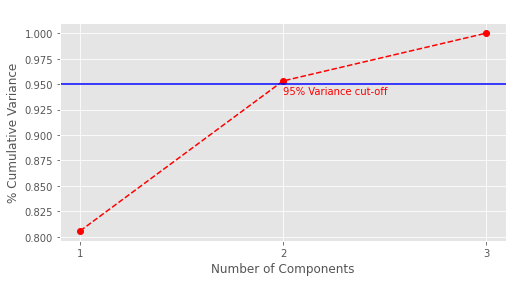

In [20]:
component_no(fds)

In [21]:
fds['Haramaya'] = fds.Districts.apply(lambda x: 0 if x == "Haramaya" else 1)
fds['Qarsa'] = fds.Districts.apply(lambda x: 0 if x == "Qarsa" else 1)
fds['Grawa'] = fds.Districts.apply(lambda x: 0 if x == "Grawa" else 1)

In [22]:
fds

,water_prc,elect_prc,tel_prc,Districts,Haramaya,Qarsa,Grawa
0,0.88,5.17,7.70,Haramaya,0,1,1
1,4.33,3.30,2.56,Grawa,1,1,0
2,7.93,2.48,1.88,Grawa,1,1,0
3,1.86,4.30,8.58,Qarsa,1,0,1
4,3.24,6.92,8.97,Haramaya,0,1,1
...,...,...,...,...,...,...,...
3595,4.66,7.14,9.07,Haramaya,0,1,1
3596,3.29,4.61,9.29,Qarsa,1,0,1
3597,5.72,2.44,3.32,Grawa,1,1,0
3598,1.26,6.35,8.80,Qarsa,1,0,1


In [23]:
from sklearn.decomposition import PCA
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "notebook_connected"
# pio.renderers.default = "vscode"


In [24]:
df = fds
features = ['water_prc', 'elect_prc', 'tel_prc', 'Haramaya', 'Qarsa', 'Grawa']
X = df[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df['Districts'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [25]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go
def kplots(df, n_init= 10, plot=True):
    """"""
    wcss = []
    for i in range(1, 11):
        model = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=n_init, random_state=42)
        model.fit(df)
        wcss.append(model.inertia_)
    k = [i*100 for i in np.diff(wcss,2)].index(min([i*100 for i in np.diff(wcss,2)]))
    if plot:
        x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=wcss,
                            mode='lines',
                            name='lines'))
        fig.update_layout(title='Elbow Method for k',
                   xaxis_title='Number of Clusters',
                   yaxis_title='Distortions')
        fig.add_vline(x=k, line_dash="dot",
              annotation_text="k = "+str(k), 
              annotation_position="top right")
        fig.show()
    return k 

In [26]:
kplots(X)

5

In [27]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=42)

# Fit and predict 
y_means = kmeans.fit_predict(X)

In [28]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ['water_prc', 'elect_prc', 'tel_prc', 'Haramaya', 'Qarsa', 'Grawa'])
centroids.index_name = "ClusterID"
centroids["ClusterID"] = centroids.index
centroids = centroids.reset_index(drop=True)

In [29]:
centroids

,water_prc,elect_prc,tel_prc,Haramaya,Qarsa,Grawa,ClusterID
0,6.267508,3.097183,2.011575,1.000000,1.000000e+00,2.331468e-15,0
1,2.004206,5.261182,9.722703,0.934122,6.587838e-02,1.000000e+00,1
2,3.461997,7.768139,7.993553,0.001692,9.983080e-01,1.000000e+00,2
3,1.484961,3.725571,10.067105,1.000000,-1.332268e-15,1.000000e+00,3
4,4.456419,6.427301,8.217630,0.012111,9.878893e-01,1.000000e+00,4


In [30]:
X_new = np.array([[1, 4, 2, 0, 1, 1]]) 
 
new_customer = kmeans.predict(X_new)
print(f"The new Consumer belongs to segment {new_customer[0]}")

The new customer belongs to segment 0


/home/miki/Desktop/Deployment/consumer-segmentation/consume/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

